In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import itertools
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# <br>
# 전처리

In [2]:
온라인 = pd.read_csv('제6회 L.POINT Big Data Competition-분석용데이터-01.온라인 행동 정보.csv', encoding='utf-8')
온라인 = 온라인.sort_values(['clnt_id','sess_id','hit_seq']).reset_index(drop=True)
온라인.shape

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(3196362, 14)

In [3]:
온라인['unique_id'] = list(map(lambda x,y: str(x)+'_'+str(y), 온라인.clnt_id, 온라인.sess_id))
온라인.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,unique_id
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app,1_1
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app,1_1
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app,1_1
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app,1_2
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app,1_2


In [4]:
# 온라인 고객: 72,399명, 고객 및 세션: 367,149개
온라인.clnt_id.nunique(), 온라인.unique_id.nunique()

(72399, 367149)

In [5]:
# 각 clnt_id별 session이 바뀌는 지점 index 저장
idx1 = 온라인.unique_id.drop_duplicates().index.tolist()
idx2 = idx1[1:] + [len(온라인)]

In [6]:
# session별 체류시간 = 다음 hit_pss_tm - 이전 hit_pss_tm
stay_tm = []
for i, j in tqdm_notebook(zip(idx1, idx2), total=len(idx1)):
    temp = 온라인.iloc[i:j].hit_pss_tm
    if len(temp) == 1:
        stay_tm.append(temp.tolist())
    else:
        temp = temp.diff().tolist()[1:]
        temp.append(temp[-1]) # 마지막은 해당 hit_pss_tm 값 사용
        stay_tm.append(temp)
    #stay_tm = stay_tm + 온라인.iloc[i:j].hit_pss_tm.diff().fillna(0).tolist()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
#stay_tm = sum(stay_tm, []) # 시간 매우 오래걸림
온라인['time_length'] = list(itertools.chain.from_iterable(stay_tm))

In [8]:
# 밀리초->초 변환
온라인['hit_pss_tm'] = np.ceil(온라인['hit_pss_tm']/1000)
온라인['time_length'] = np.ceil(온라인['time_length']/1000)

In [9]:
# 주말 및 공휴일 여부
holiday_diff = []
for i in 온라인.sess_dt.map(lambda x: str(x)[-3:]).tolist():
    if i in (['706','707','713','714','717','720','721','727','728',
               '803','804','810','811','815','817','818','824','825',
               '907','908','912','913','914','915','921','922','928','929']):
        holiday_diff.append(1)
    else:
        holiday_diff.append(0)
온라인['holiday_diff'] = holiday_diff

In [10]:
# keyword: session별 sech_kwd의 cumulative sum
온라인['sech_kwd'] = 온라인.sech_kwd.map(lambda x: 0 if str(x) == 'nan' else 1)
keyword = []
for i, j in tqdm_notebook(zip(idx1, idx2), total=len(idx1)):
    temp = 온라인.iloc[i:j].sech_kwd
    keyword.append(np.cumsum(temp.tolist()))
온라인['keyword'] = list(itertools.chain.from_iterable(keyword))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [11]:
온라인['sess_dt'] = 온라인['sess_dt'].map(lambda x: str(x)[:-2]) # day제거하고 month(7,8,9월)만 남김
온라인['dvc_ctg_nm'].fillna('unknown',inplace=True) # device null값을 unknown으로 대체

# dummy variable 생성 - action_type, biz_unit, sess_dt, trfc_src, dvc_ctg_nm
온라인 = pd.concat([온라인, pd.get_dummies(온라인[['biz_unit','sess_dt','trfc_src','dvc_ctg_nm']], drop_first=True)], axis=1)
온라인 = pd.concat([온라인, pd.get_dummies(온라인.action_type, drop_first=True, prefix='action_type')], axis=1)
온라인 = 온라인.drop(['action_type','biz_unit','sess_dt','hit_tm','sech_kwd','tot_pag_view_ct', 'tot_sess_hr_v','trfc_src','dvc_ctg_nm'], axis=1)

In [12]:
온라인 = 온라인[['clnt_id', 'sess_id', 'trans_id', 'hit_seq', 'hit_pss_tm', 'time_length', 'holiday_diff', 'keyword',
                'action_type_1', 'action_type_2', 'action_type_3','action_type_4', 'action_type_5', 'action_type_6', 'action_type_7',
                'biz_unit_A02', 'biz_unit_A03', 'sess_dt_201908', 'sess_dt_201909', 
                'trfc_src_PORTAL_1', 'trfc_src_PORTAL_2', 'trfc_src_PORTAL_3', 'trfc_src_PUSH', 'trfc_src_WEBSITE', 'trfc_src_unknown', 
                'dvc_ctg_nm_mobile_app','dvc_ctg_nm_mobile_web', 'dvc_ctg_nm_unknown', 'unique_id']]
print(온라인.shape)
온라인.head()

(3196362, 29)


,clnt_id,sess_id,trans_id,hit_seq,hit_pss_tm,time_length,holiday_diff,keyword,action_type_1,action_type_2,...,trfc_src_PORTAL_1,trfc_src_PORTAL_2,trfc_src_PORTAL_3,trfc_src_PUSH,trfc_src_WEBSITE,trfc_src_unknown,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,unique_id
0,1,1,NaN,1,12.0,11.0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,1_1
1,1,1,NaN,2,23.0,14.0,0,2,0,0,...,0,0,0,0,0,1,1,0,0,1_1
2,1,1,NaN,3,37.0,14.0,0,3,0,0,...,0,0,0,0,0,1,1,0,0,1_1
3,1,2,NaN,1,42.0,15.0,1,1,0,0,...,0,0,0,0,0,1,1,0,0,1_2
4,1,2,NaN,2,57.0,14.0,1,2,0,0,...,0,0,0,0,0,1,1,0,0,1_2


In [ ]:
# 저장하고 가자
온라인.to_csv('온라인_전처리_final.csv', index=False)

In [ ]:
# 각 hit_seq 당 action_type이 구매완료=1, 이외=0
온라인['buy'] = 온라인['action_type_6']
온라인 = 온라인.drop('action_type_6', axis=1)
print(온라인.shape)
온라인.head()

In [ ]:
#구매 세션의 비율
온라인['buy'].value_counts()[1]/(온라인['buy'].value_counts()[0]+온라인['buy'].value_counts()[1])

In [ ]:
#다음 세션의 구매를 예측하기 위한 종속변수 생성
구매여부 = 온라인[['clnt_id', 'sess_id', 'buy']].groupby(['clnt_id', 'sess_id']).sum()
구매여부.buy = 구매여부.buy.apply(lambda x:0 if x == 0 else 1)
구매여부 = 구매여부.sort_index()
구매여부 = 구매여부.reset_index()
#각 clnt_id별로 shift로 1행씩 올림
#구매여부.buy = 구매여부.buy.shift(-1)
g = 구매여부.groupby('clnt_id')
#1행씩 올리면 각 clnt_id별로 마지막 값은 다음 id의 값, 따라서 마지막 행 제거
#구매여부.drop(g.tail(1).index,axis = 0, inplace = True)

In [ ]:
구매여부

In [ ]:
구매여부1 = pd.DataFrame()
for id in tqdm_notebook(구매여부['clnt_id'].unique()):
    temp = 구매여부[구매여부['clnt_id'] == id]
    temp.buy = temp.buy.shift(-5)
    temp = temp.dropna(axis = 0)
    구매여부1 = pd.concat([구매여부1, temp])

In [ ]:
온라인.drop(['buy'], axis =1, inplace= True)
온라인 = pd.merge(온라인, 구매여부1, left_on = ['clnt_id', 'sess_id'], right_on = ['clnt_id', 'sess_id'])

In [ ]:
온라인.shape

In [ ]:
#windowing을 위해 세션 3개씩 하나로 묶음
온라인1 = pd.DataFrame()
for id in tqdm_notebook(온라인['clnt_id'].unique()):
    temp = 온라인[온라인['clnt_id'] == id]
    for i in range(1, temp['sess_id'].nunique()-1):
        new_temp = temp[(temp['sess_id'] >= i) & (temp['sess_id'] <= i+1)]
        new_temp.sess_id = i
        new_temp.buy = list(new_temp.buy)[0]
        온라인1= pd.concat([온라인1,new_temp])
        

In [ ]:
온라인1.shape

In [ ]:
온라인1.head()

In [ ]:
온라인1.to_csv('다음 세션 구매 예측_5개단위.csv', index= False)

# <br>
# 모델링

In [ ]:
온라인 = pd.read_csv('다음 세션 구매 예측_5개단위.csv')

In [ ]:
온라인.clnt_id.nunique()

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers import Masking
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical

In [ ]:
import os

In [ ]:
import keras.backend.tensorflow_backend as KTF

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.compat.v1.Session(config=config)

KTF.set_session(session)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def make_padding_and_oversample(X, Y, length=350):
    max_len = length #np.percentile(pd.Series(idx),99)
    X_padding = sequence.pad_sequences(X, maxlen=max_len, padding='pre', truncating='post')
    X_padding2 = X_padding.reshape(X.shape[0], max_len* X_padding.shape[2])

    smote = SMOTE(random_state=0)
    X_resampled, Y_resampled = smote.fit_resample(X_padding2, Y)
    X_resampled = X_resampled.reshape(X_resampled.shape[0], max_len, X_padding.shape[2])
    return X_padding, X_resampled, Y_resampled

## 각 session의 첫번째 구매완료 이전까지 data만 사용

In [ ]:
# 고객별 세션당 구매 횟수: 0~25까지 다양함
# 우선 첫번째 구매를 기준으로 자름
온라인.groupby('unique_id').buy.sum().value_counts()

In [ ]:
idx3 = []
for i, j in tqdm_notebook(zip(idx1, idx2), total=len(idx1)):
    temp = 온라인.buy.iloc[i:j]
    try:
        idx3.append(temp[temp == 1].index[0])
    except:
        idx3.append(j)

In [ ]:
# (session, sequence, variables) 3d array 변환
온라인_x = []
for i, j in tqdm_notebook(zip(idx1, idx3), total=len(idx1)):
    온라인_x.append(온라인.iloc[i:j, 3:-2].values)
    
#scaler = StandardScaler() 
#scaler = MinMaxScaler(feature_range=(0, 1))
#온라인_x = scaler.fit_transform(np.array(온라인_x))
온라인_x = np.array(온라인_x)

In [ ]:
# session 당 구매 여부
온라인_y = []
for i,j in tqdm_notebook(zip(idx1,idx2), total=len(idx1)):
    온라인_y.append([int(온라인.buy.iloc[i:j].sum()>0)])

In [ ]:
len(온라인_y)

In [ ]:
# 구매완료한 session이 전체의 약 13%
#pd.Series(온라인_y).value_counts()*100/온라인.unique_id.nunique()

In [ ]:
idx = list(pd.Series(idx2) - pd.Series(idx1))
np.percentile(pd.Series(idx),99)

In [ ]:
idx = list(pd.Series(idx3) - pd.Series(idx1))
np.percentile(pd.Series(idx),99)

In [ ]:
X_padded, X_resampled, Y_resampled = make_padding_and_oversample(온라인_x, 온라인_y, length=140)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [42]:
def models(train):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(train.shape[1], train.shape[2])))
    model.add(LSTM(64,input_shape = (train.shape[1], train.shape[2])))
    model.add(Dense(32, activation= 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation= 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc',f1_m,precision_m, recall_m])
    return model

In [43]:
model = models(X_train)
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 350, 24)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                22784     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 25,409
Train

In [44]:
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=2, shuffle=True)


Train on 430386 samples, validate on 184452 samples
Epoch 1/25
 - 335s - loss: 0.3067 - acc: 0.9444 - f1_m: 0.9389 - precision_m: 0.9834 - recall_m: 0.8993 - val_loss: 0.1229 - val_acc: 0.9614 - val_f1_m: 0.9601 - val_precision_m: 0.9945 - val_recall_m: 0.9281
Epoch 2/25
 - 244s - loss: 0.1254 - acc: 0.9604 - f1_m: 0.9592 - precision_m: 0.9902 - recall_m: 0.9304 - val_loss: 0.1058 - val_acc: 0.9647 - val_f1_m: 0.9636 - val_precision_m: 0.9977 - val_recall_m: 0.9318
Epoch 3/25
 - 222s - loss: 0.1116 - acc: 0.9645 - f1_m: 0.9634 - precision_m: 0.9913 - recall_m: 0.9373 - val_loss: 0.1157 - val_acc: 0.9642 - val_f1_m: 0.9638 - val_precision_m: 0.9753 - val_recall_m: 0.9527
Epoch 4/25
 - 221s - loss: 0.1038 - acc: 0.9668 - f1_m: 0.9659 - precision_m: 0.9918 - recall_m: 0.9417 - val_loss: 0.1012 - val_acc: 0.9713 - val_f1_m: 0.9710 - val_precision_m: 0.9832 - val_recall_m: 0.9592
Epoch 5/25
 - 221s - loss: 0.1001 - acc: 0.9679 - f1_m: 0.9671 - precision_m: 0.9908 - recall_m: 0.9447 - val_l

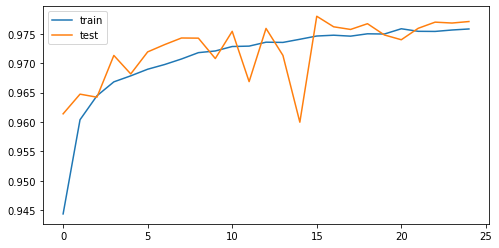

In [45]:
# plot history
plt.figure(figsize=(8,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [46]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)

184452/184452 [==============================] - 1026s 6ms/step


In [47]:
print(accuracy)

0.9770888686180115


## 구매완료 이전의 hit_seq를 버림
### 각 sequence length의 0.25-0.75배 random값

In [40]:
import random
remove_ratio = pd.Series([random.random() for i in range(len(온라인_x))]) + 0.5
seq_length = pd.Series(온라인_x).map(lambda x: len(x))
remove_seq_length = np.floor(remove_ratio*seq_length)/2 # 각 session에서 버릴 seq 개수

In [41]:
온라인_x2 = list(map(lambda x,y: x[:-y] if y !=0 else x, 
                     pd.Series(온라인_x), 
                     remove_seq_length.astype(int)))

In [42]:
seq_length2 = pd.Series(온라인_x2).map(lambda x: len(x))
max_len = np.percentile(seq_length2, 99)
max_len

28.0

In [51]:
X_padded, X_resampled, Y_resampled = make_padding_and_oversample(np.array(온라인_x2), 온라인_y, length=int(max_len))
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)
X_train.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(410033, 28, 24)

In [52]:
model = models(X_train)
# model.summary()

In [53]:
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=1, shuffle=True)

Train on 410033 samples, validate on 175729 samples
Epoch 1/25
410033/410033 [==============================] - 22s 53us/step - loss: 0.4995 - acc: 0.7966 - f1_m: 0.7955 - precision_m: 0.7957 - recall_m: 0.7978 - val_loss: 0.4457 - val_acc: 0.8159 - val_f1_m: 0.8171 - val_precision_m: 0.8130 - val_recall_m: 0.8216
Epoch 2/25
410033/410033 [==============================] - 21s 51us/step - loss: 0.4397 - acc: 0.8236 - f1_m: 0.8277 - precision_m: 0.8096 - recall_m: 0.8488 - val_loss: 0.4180 - val_acc: 0.8307 - val_f1_m: 0.8317 - val_precision_m: 0.8280 - val_recall_m: 0.8358
Epoch 3/25
410033/410033 [==============================] - 21s 51us/step - loss: 0.4266 - acc: 0.8315 - f1_m: 0.8362 - precision_m: 0.8142 - recall_m: 0.8615 - val_loss: 0.4098 - val_acc: 0.8401 - val_f1_m: 0.8483 - val_precision_m: 0.8080 - val_recall_m: 0.8932
Epoch 4/25
410033/410033 [==============================] - 21s 52us/step - loss: 0.4171 - acc: 0.8361 - f1_m: 0.8408 - precision_m: 0.8172 - recall_m: 0.86

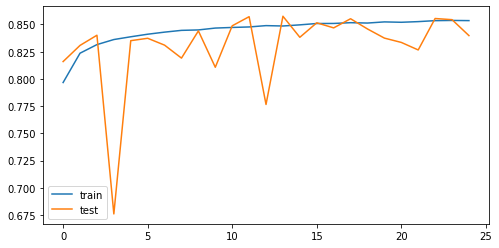

In [54]:
# plot history
plt.figure(figsize=(8,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()                                       
plt.show()

In [55]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)

175729/175729 [==============================] - 107s 607us/step


In [56]:
print(accuracy)

0.8397646546363831


### 각 sequence length의 0.5-0.75배 random값

In [57]:
remove_ratio = pd.Series([random.random() for i in range(len(온라인_x))]) + 2
remove_seq_length = np.floor(remove_ratio*seq_length)/4

온라인_x2 = list(map(lambda x,y: x[:-y] if y !=0 else x, 
                     pd.Series(온라인_x), 
                     remove_seq_length.astype(int)))

seq_length2 = pd.Series(온라인_x2).map(lambda x: len(x))
max_len = np.percentile(seq_length2,99)
max_len

20.0

In [58]:
X_padded, X_resampled, Y_resampled = make_padding_and_oversample(np.array(온라인_x2), 온라인_y,length = int(max_len))
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)
X_train.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(410033, 20, 24)

In [59]:
model = models(X_train)
# model.summary()
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=1, shuffle=True)

Train on 410033 samples, validate on 175729 samples
Epoch 1/25
410033/410033 [==============================] - 16s 40us/step - loss: 0.5124 - acc: 0.7935 - f1_m: 0.7914 - precision_m: 0.7907 - recall_m: 0.7954 - val_loss: 0.4535 - val_acc: 0.8192 - val_f1_m: 0.8254 - val_precision_m: 0.7988 - val_recall_m: 0.8541
Epoch 2/25
410033/410033 [==============================] - 16s 38us/step - loss: 0.4457 - acc: 0.8204 - f1_m: 0.8244 - precision_m: 0.8055 - recall_m: 0.8467 - val_loss: 0.4198 - val_acc: 0.8343 - val_f1_m: 0.8381 - val_precision_m: 0.8204 - val_recall_m: 0.8569
Epoch 3/25
410033/410033 [==============================] - 16s 38us/step - loss: 0.4312 - acc: 0.8282 - f1_m: 0.8325 - precision_m: 0.8112 - recall_m: 0.8570 - val_loss: 0.4195 - val_acc: 0.8278 - val_f1_m: 0.8282 - val_precision_m: 0.8272 - val_recall_m: 0.8295
Epoch 4/25
410033/410033 [==============================] - 16s 38us/step - loss: 0.4236 - acc: 0.8323 - f1_m: 0.8367 - precision_m: 0.8143 - recall_m: 0.86

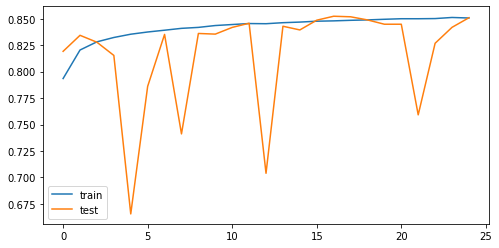

In [60]:
# plot history
plt.figure(figsize=(8,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()                                       
plt.show()

In [61]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)

175729/175729 [==============================] - 81s 460us/step


In [62]:
print(accuracy)

0.8509352207183838


### 각 sequence length의 0.5배 값

In [63]:
remove_seq_length = np.floor(0.5*seq_length)
온라인_x2 = list(map(lambda x,y: x[:-y] if y !=0 else x, 
                     pd.Series(온라인_x), 
                     remove_seq_length.astype(int)))
seq_length2 = pd.Series(온라인_x2).map(lambda x: len(x))
max_len = np.percentile(seq_length2,99)
max_len

26.0

In [64]:
X_padded, X_resampled, Y_resampled = make_padding_and_oversample(np.array(온라인_x2), 온라인_y, length= int(max_len))
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)
X_train.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(410033, 26, 24)

In [65]:
model = models(X_train)
# model.summary()
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=1, shuffle=True)

Train on 410033 samples, validate on 175729 samples
Epoch 1/25
410033/410033 [==============================] - 20s 49us/step - loss: 0.5006 - acc: 0.7987 - f1_m: 0.7974 - precision_m: 0.7954 - recall_m: 0.8027 - val_loss: 0.4393 - val_acc: 0.8217 - val_f1_m: 0.8225 - val_precision_m: 0.8198 - val_recall_m: 0.8257
Epoch 2/25
410033/410033 [==============================] - 20s 48us/step - loss: 0.4366 - acc: 0.8250 - f1_m: 0.8294 - precision_m: 0.8085 - recall_m: 0.8533 - val_loss: 0.4817 - val_acc: 0.8018 - val_f1_m: 0.8232 - val_precision_m: 0.7439 - val_recall_m: 0.9217
Epoch 3/25
410033/410033 [==============================] - 20s 48us/step - loss: 0.4234 - acc: 0.8317 - f1_m: 0.8365 - precision_m: 0.8134 - recall_m: 0.8629 - val_loss: 0.4353 - val_acc: 0.8274 - val_f1_m: 0.8322 - val_precision_m: 0.8108 - val_recall_m: 0.8551
Epoch 4/25
410033/410033 [==============================] - 20s 49us/step - loss: 0.4166 - acc: 0.8357 - f1_m: 0.8400 - precision_m: 0.8163 - recall_m: 0.86

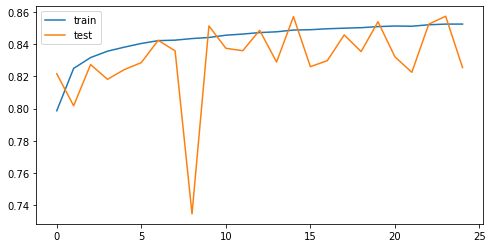

In [66]:
# plot history
plt.figure(figsize=(8,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()                                       
plt.show()

In [67]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)

175729/175729 [==============================] - 101s 574us/step


In [68]:
print(accuracy, f1_score, precision, recall)

0.8254926800727844 0.8378955125808716 0.7711088061332703 0.9269371628761292


# Conv1D + LSTM

In [69]:
model = Sequential()
#model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(64, 5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 5, activation='relu'))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.5))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc',f1_m,precision_m, recall_m])
#print(model.summary())

In [70]:
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=1, shuffle=True)

Train on 410033 samples, validate on 175729 samples
Epoch 1/25
410033/410033 [==============================] - 8s 21us/step - loss: 0.6648 - acc: 0.5930 - f1_m: 0.6640 - precision_m: 0.5636 - recall_m: 0.8112 - val_loss: 0.6569 - val_acc: 0.6010 - val_f1_m: 0.6768 - val_precision_m: 0.5695 - val_recall_m: 0.8347
Epoch 2/25
410033/410033 [==============================] - 6s 16us/step - loss: 0.6510 - acc: 0.6067 - f1_m: 0.6844 - precision_m: 0.5714 - recall_m: 0.8541 - val_loss: 0.6537 - val_acc: 0.6026 - val_f1_m: 0.7037 - val_precision_m: 0.5617 - val_recall_m: 0.9424
Epoch 3/25
410033/410033 [==============================] - 6s 16us/step - loss: 0.6380 - acc: 0.6185 - f1_m: 0.6978 - precision_m: 0.5772 - recall_m: 0.8833 - val_loss: 0.6279 - val_acc: 0.6296 - val_f1_m: 0.7068 - val_precision_m: 0.5856 - val_recall_m: 0.8919
Epoch 4/25
410033/410033 [==============================] - 6s 16us/step - loss: 0.6286 - acc: 0.6276 - f1_m: 0.7044 - precision_m: 0.5837 - recall_m: 0.8893 -

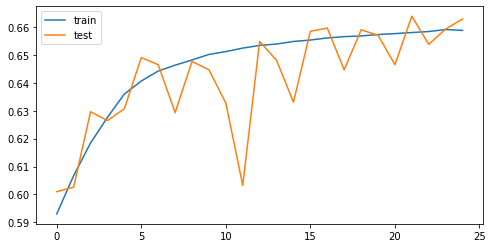

In [71]:
# plot history
plt.figure(figsize=(8,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()                                       
plt.show()

In [72]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)

175729/175729 [==============================] - 22s 126us/step


In [73]:
print(accuracy)

0.662855863571167


In [74]:
model = Sequential()
#model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(128, 5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 5, activation='relu'))
model.add(LSTM(32))
model.add(Dense(32, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc',f1_m,precision_m, recall_m])
#print(model.summary())

In [75]:
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=1, shuffle=True)

Train on 410033 samples, validate on 175729 samples
Epoch 1/25
410033/410033 [==============================] - 8s 19us/step - loss: 0.6633 - acc: 0.5942 - f1_m: 0.6640 - precision_m: 0.5642 - recall_m: 0.8119 - val_loss: 0.6591 - val_acc: 0.6019 - val_f1_m: 0.6698 - val_precision_m: 0.5729 - val_recall_m: 0.8066
Epoch 2/25
410033/410033 [==============================] - 7s 17us/step - loss: 0.6510 - acc: 0.6071 - f1_m: 0.6865 - precision_m: 0.5713 - recall_m: 0.8612 - val_loss: 0.6426 - val_acc: 0.6173 - val_f1_m: 0.6962 - val_precision_m: 0.5779 - val_recall_m: 0.8759
Epoch 3/25
410033/410033 [==============================] - 7s 17us/step - loss: 0.6384 - acc: 0.6194 - f1_m: 0.6954 - precision_m: 0.5793 - recall_m: 0.8709 - val_loss: 0.6698 - val_acc: 0.5962 - val_f1_m: 0.7010 - val_precision_m: 0.5572 - val_recall_m: 0.9453
Epoch 4/25
410033/410033 [==============================] - 7s 17us/step - loss: 0.6285 - acc: 0.6275 - f1_m: 0.7015 - precision_m: 0.5851 - recall_m: 0.8771 -

In [76]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)

175729/175729 [==============================] - 23s 128us/step


In [77]:
accuracy, f1_score, precision, recall

(0.660983681678772, 0.7257249355316162, 0.6068738698959351, 0.9180732369422913)

# <br>
# sensitivity analysis

In [78]:
## Sensitivity Analysis
full_X_c = 온라인.iloc[:,3:-2].columns
a_features = int(X_train.shape[2])
importance_df = pd.DataFrame(np.zeros((a_features, 2)), 
                             columns=['varible_name', 'perturbation_effect'])
a_features, len(full_X_c)

(24, 24)

In [79]:
def var_importance(model):
    x = X_test # Get a sample of data
    orig_out = model.predict(x)
    for i in tqdm_notebook(range(a_features)):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size= new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5 #RMSE
        importance_df.iloc[i,0] = full_X_c[i]
        importance_df.iloc[i,1] = effect
        print(f'Variable {i+1}, perturbation effect: {effect:.4f}')

var_importance(model)
importance_df = importance_df.sort_values(by='perturbation_effect', ascending=False)
print(importance_df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Variable 1, perturbation effect: 0.0104
Variable 2, perturbation effect: 0.0031
Variable 3, perturbation effect: 0.0031
Variable 4, perturbation effect: 0.0141
Variable 5, perturbation effect: 0.0400
Variable 6, perturbation effect: 0.0527
Variable 7, perturbation effect: 0.0720
Variable 8, perturbation effect: 0.0802
Variable 9, perturbation effect: 0.0447
Variable 10, perturbation effect: 0.0736
Variable 11, perturbation effect: 0.0068
Variable 12, perturbation effect: 0.0168
Variable 13, perturbation effect: 0.0501
Variable 14, perturbation effect: 0.0212
Variable 15, perturbation effect: 0.0204
Variable 16, perturbation effect: 0.0080
Variable 17, perturbation effect: 0.0060
Variable 18, perturbation effect: 0.0023
Variable 19, perturbation effect: 0.0101
Variable 20, perturbation effect: 0.0102
Variable 21, perturbation effect: 0.0299
Variable 22, perturbation effect: 0.0253
Variable 23, perturbation effect: 0.0247
Variable 24, perturbation effect: 0.0479

             varible_nam

In [80]:
importance_df

,varible_name,perturbation_effect
7,action_type_3,0.080201
9,action_type_5,0.073612
6,action_type_2,0.072028
5,action_type_1,0.052746
12,biz_unit_A03,0.050135
23,dvc_ctg_nm_unknown,0.047884
8,action_type_4,0.044704
4,keyword,0.039988
20,trfc_src_unknown,0.029946
21,dvc_ctg_nm_mobile_app,0.025260


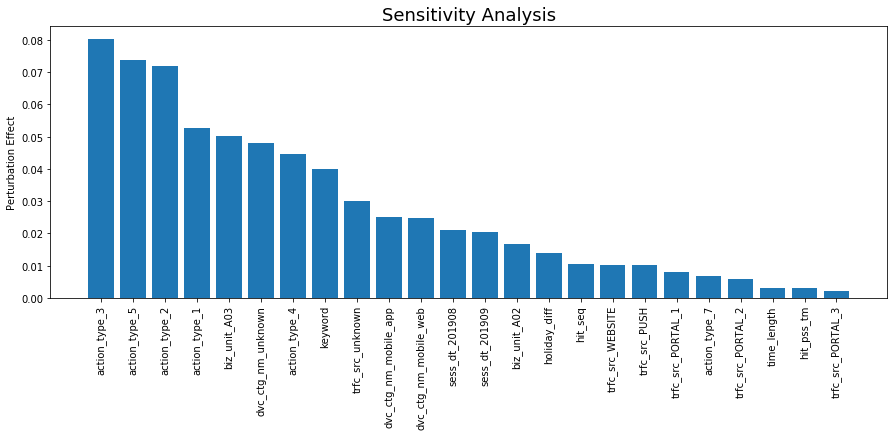

In [81]:
## Plot 예시
#mpl.rc('font', family='New Gulim')
#mpl.rc('axes', unicode_minus=False)
plt.subplots(figsize=(15,5))
plt.bar(importance_df.iloc[:,0], importance_df.iloc[:,1])
plt.title('Sensitivity Analysis', fontsize=18)
#plt.xlabel('IV')
plt.ylabel('Perturbation Effect')
plt.xticks(importance_df.iloc[:,0], rotation=90)
plt.show()

In [82]:
importance_df.perturbation_effect.mean()

0.028063864674639002